In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import os.path

%matplotlib inline

sns.set(style="ticks", color_codes=True)

In [2]:
PATH = 'data/'

In [3]:
if  os.path.exists(PATH + 'full_train.csv') and os.path.exists(PATH + 'full_test.csv'):
    
    #check for the full train and test set
    df_train = pd.read_csv(PATH + 'full_train.csv')
    df_test = pd.read_csv(PATH + 'full_test.csv')
else:
    
    # Load train and test data
    df_train = pd.read_csv(PATH + 'train.csv')
    df_test = pd.read_csv(PATH + 'test.csv')
    df_struct = pd.read_csv(PATH + 'Building_Structure.csv')
    df_own = pd.read_csv(PATH + 'Building_Ownership_Use.csv')

    df_merge = pd.merge(df_struct,df_own,on=['building_id', 'district_id', 'vdcmun_id', 'ward_id'])
    df_train = pd.merge(df_train,df_merge,on=['building_id', 'district_id', 'vdcmun_id'])
    df_test  = pd.merge(df_test, df_merge, on =['building_id', 'district_id', 'vdcmun_id'])

    del df_struct, df_own

    df_train["has_repair_started"].fillna(0.0,inplace=True)
    df_test["has_repair_started"].fillna(0.0,inplace=True)
    df_train["count_families"].fillna(1.0,inplace=True)

    df_train.to_csv(PATH + 'full_train.csv',index=False)
    df_test.to_csv(PATH + 'full_test.csv',index=False)


In [4]:
def clean_land_surface_condition(raw):
    if raw.lower() != 'flat':
        return "slope"
    else:
        return raw.lower()

def clean_plan_configuration(raw):
    if raw.lower() != 'rectangular':
        return "others"
    else:
        return raw.lower()

def clean_position(raw):
    if raw.lower() != 'not attached':
        return "attached"
    else:
        return raw.lower()

def clean_ground_floor_type(raw):
    if 'mud' in raw.lower():
        return 'mud'
    else:
        return 'hard_floor'

def clean_area_assesed(raw):
    if raw.lower() == 'exterior' or raw.lower() == 'interior':
        return 'visible'
    else:
        return raw.lower()

def clean_foundation_type(raw):
    if 'mud' in raw.lower():
        return 'mud'
    elif 'bamboo' in raw.lower():
        return 'wooden'
    else:
        return 'cemented'

def clean_roof_type(raw):
    if 'light roof' in raw.lower():
        return 'light roof'
    elif 'heavy roof' in raw.lower():
        return 'heavy roof'
    else:
        return 'rcc'

In [5]:
datasets = [df_train, df_test]

for dataset in datasets:
    
    dataset.land_surface_condition = dataset.land_surface_condition.apply(clean_land_surface_condition)

    dataset.plan_configuration = dataset.plan_configuration.apply(clean_plan_configuration)

    dataset.position = dataset.position.apply(clean_position)

    dataset.ground_floor_type = dataset.ground_floor_type.apply(clean_ground_floor_type)

    dataset.area_assesed = dataset.area_assesed.apply(clean_area_assesed)

    dataset.foundation_type = dataset.foundation_type.apply(clean_foundation_type)

    dataset.roof_type = dataset.roof_type.apply(clean_roof_type)

    dataset['isBuildingOld'] = (dataset.age_building > 30).astype('int')

    dataset['isFloorRemoved'] = ((dataset['count_floors_pre_eq']-dataset['count_floors_post_eq']) > 0 ).astype('int')

    dataset['isHeightChanged'] = ((dataset.height_ft_pre_eq - dataset.height_ft_post_eq) > 0 ).astype('int')

In [6]:
cols_to_drop = ['has_geotechnical_risk_fault_crack', 'has_geotechnical_risk_flood',
                'has_geotechnical_risk_land_settlement', 'has_geotechnical_risk_landslide',
                'has_geotechnical_risk_liquefaction', 'has_geotechnical_risk_other', 
                'has_geotechnical_risk_rock_fall','has_secondary_use_agriculture',
                'has_secondary_use_hotel', 'has_secondary_use_rental',
                'has_secondary_use_institution', 'has_secondary_use_school',
                'has_secondary_use_industry', 'has_secondary_use_health_post',
                'has_secondary_use_gov_office', 'has_secondary_use_use_police',
                'has_secondary_use_other','legal_ownership_status','age_building',
                'count_floors_pre_eq','count_floors_post_eq','height_ft_pre_eq','height_ft_post_eq',
                'has_superstructure_adobe_mud', 'has_superstructure_stone_flag', 
                'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 
                'has_superstructure_cement_mortar_brick', 'has_superstructure_other',
                'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
                'has_superstructure_rc_engineered']

df_train.drop(columns=cols_to_drop,inplace=True,axis=1)
df_test.drop(columns=cols_to_drop,inplace=True,axis=1)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


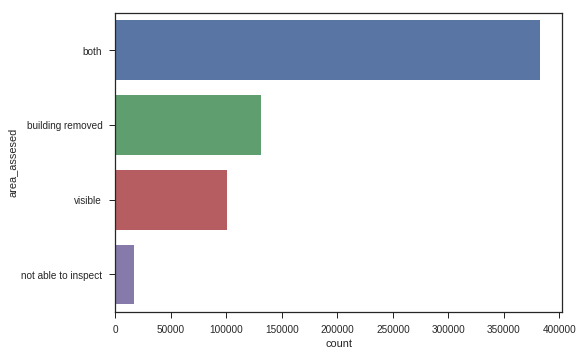

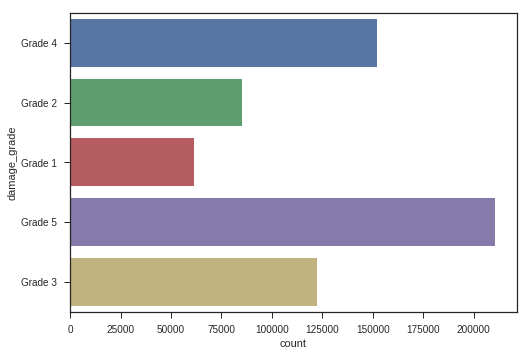

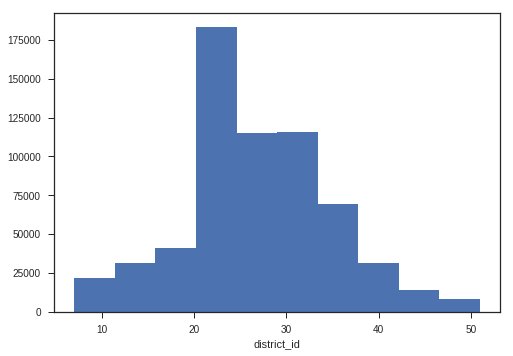

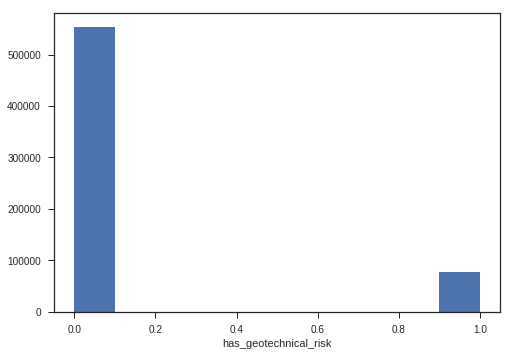

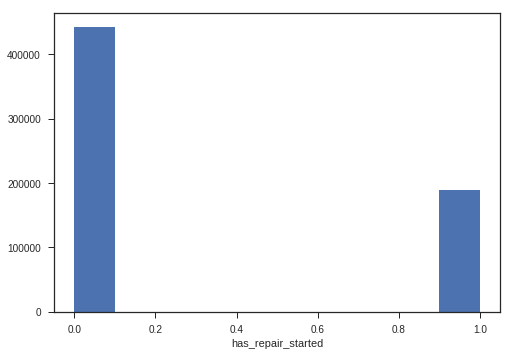

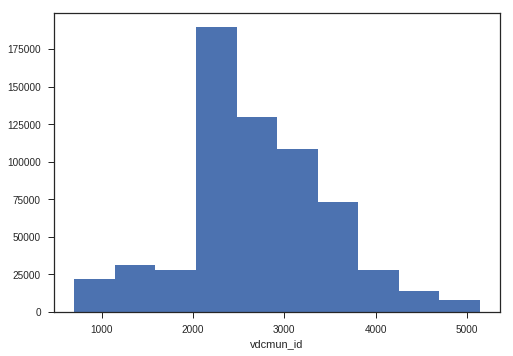

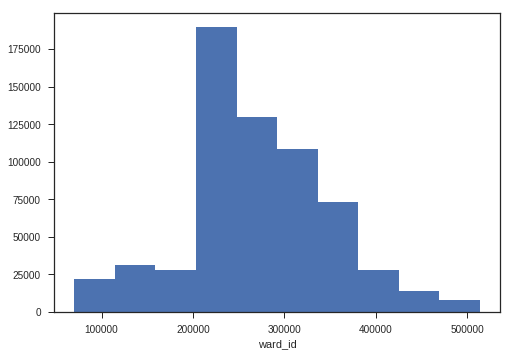

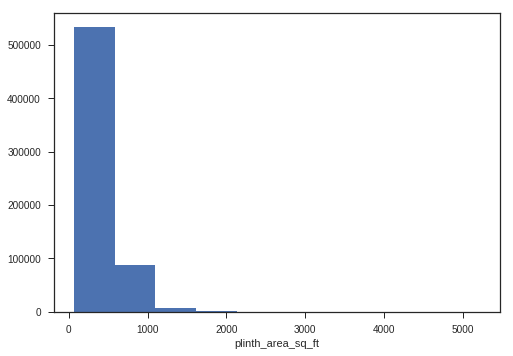

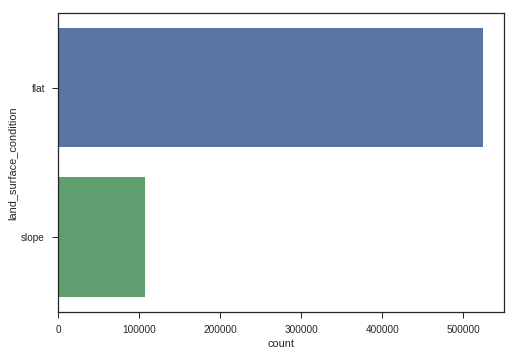

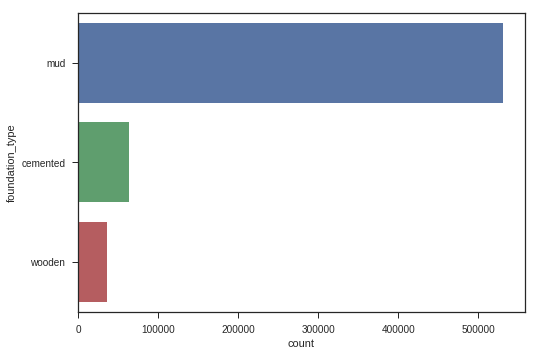

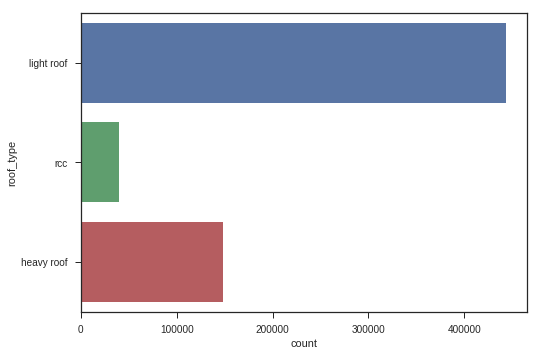

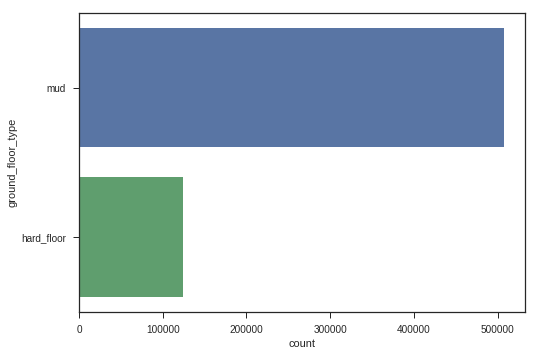

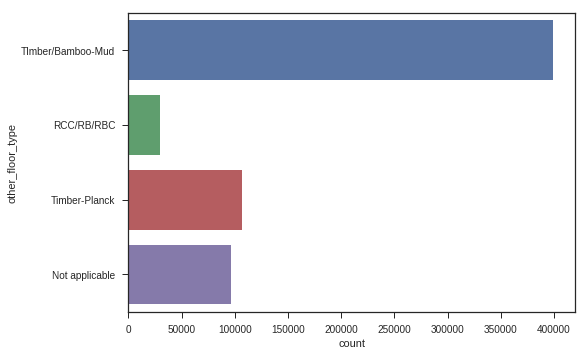

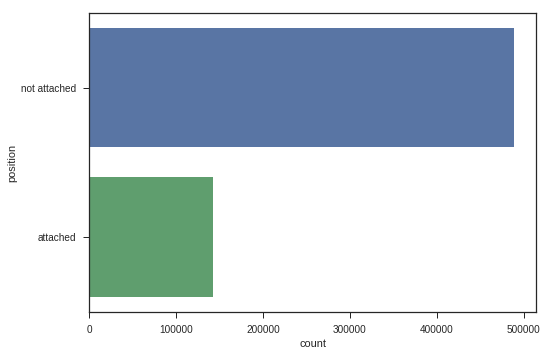

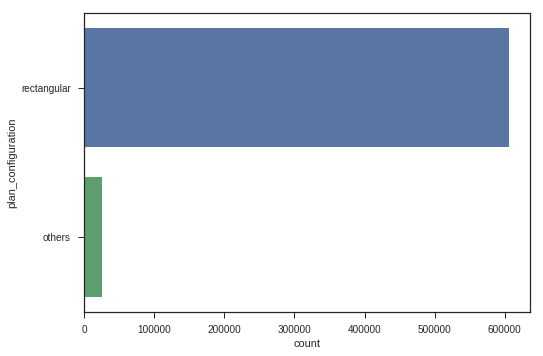

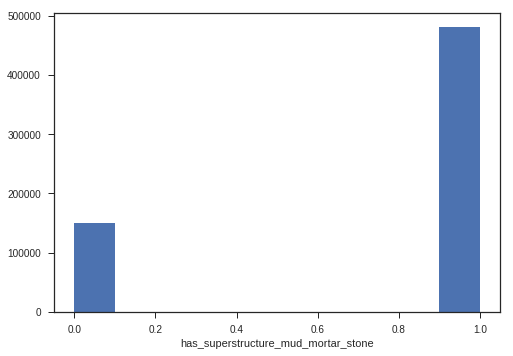

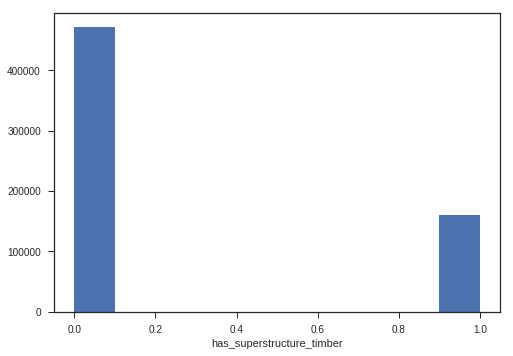

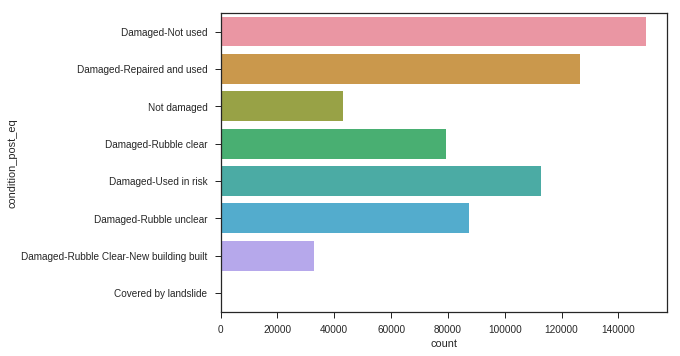

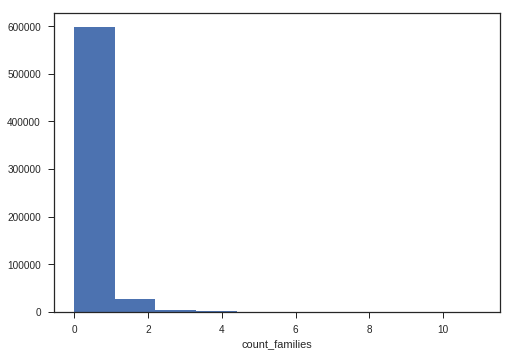

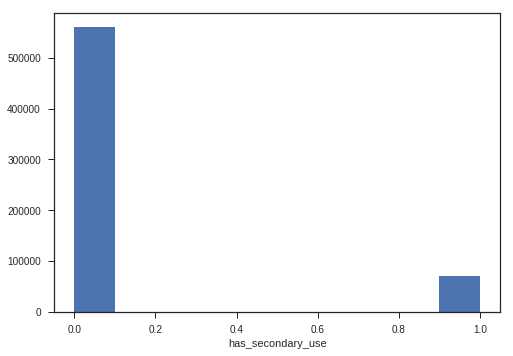

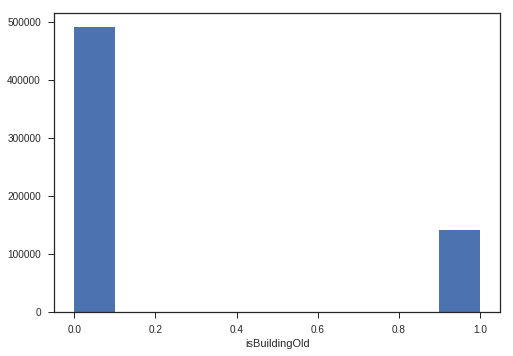

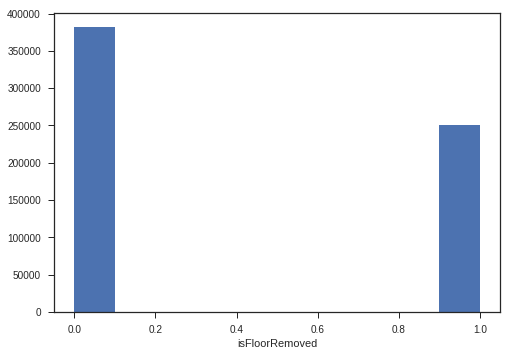

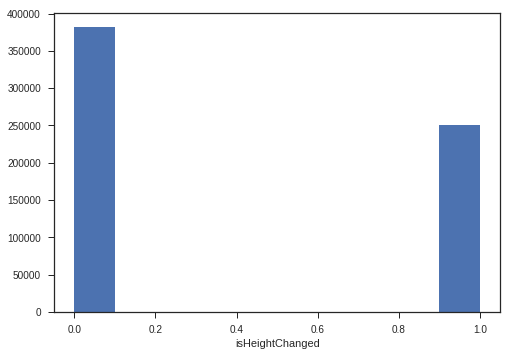

In [7]:
for col in df_train.columns.tolist():
    if col != 'building_id':
        if df_train[col].dtype == 'object':
            sns.countplot(y=col,data=df_train)
            plt.show()
        else:
            plt.xlabel(col)
            plt.hist(x=col,data=df_train)
            plt.show()

In [8]:
features_to_encode = ["area_assesed","foundation_type", "land_surface_condition","roof_type",
                      "ground_floor_type","other_floor_type","position","plan_configuration","condition_post_eq"]
df_train = pd.get_dummies(df_train, columns=features_to_encode)
df_test  = pd.get_dummies(df_test, columns=features_to_encode)

In [9]:
df_train.drop(columns=['condition_post_eq_Covered by landslide'],inplace=True,axis=1)
df_test.drop(columns=['condition_post_eq_Covered by landslide'],inplace=True,axis=1)

In [10]:
from sklearn.preprocessing import LabelEncoder

target = df_train.damage_grade
le = LabelEncoder().fit(target)

Y = le.transform(target)

In [11]:
X = df_train.drop(columns=['building_id','damage_grade'],axis=1)

In [12]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [13]:
rf = RandomForestClassifier().fit(X_train,Y_train)

In [14]:
f1_score(Y_train,rf.predict(X_train),average='weighted')

0.969647993874588

In [15]:
preds = rf.predict(X_test)

In [16]:
f1_score(Y_test,preds,average='weighted')

0.7412649967928259

In [32]:
from imblearn.combine import SMOTETomek

smotet = SMOTETomek(random_state=42,m=10)
X, Y = smotet.fit_sample(X,Y)
X= pd.DataFrame(X)
y=pd.DataFrame(Y)

/usr/local/lib/python3.6/dist-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


In [24]:
submission.head()

,building_id,damage_grade
0,a3380c4f75,Grade 3
1,a338a4e653,Grade 5
2,a338a4e6b7,Grade 5
3,a33a6eaa3a,Grade 3
4,a33b073ff6,Grade 5


In [13]:
import xgboost as xgb

In [14]:
dtrain = xgb.DMatrix(X_train,label=Y_train)
dtest = xgb.DMatrix(X_test,label=Y_test)

In [15]:
param = {
    'max_depth': 6,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 5}  # the number of classes that exist in this datset
num_round = 500  # the number of training iterations

In [16]:
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [17]:
bst = xgb.train(param,dtrain,num_round,evallist,early_stopping_rounds=200)

[0]	eval-merror:0.28847	train-merror:0.286938
Multiple eval metrics have been passed: 'train-merror' will be used for early stopping.

Will train until train-merror hasn't improved in 200 rounds.
[1]	eval-merror:0.288406	train-merror:0.286505
[2]	eval-merror:0.28691	train-merror:0.285656
[3]	eval-merror:0.286594	train-merror:0.285158
[4]	eval-merror:0.285549	train-merror:0.283973
[5]	eval-merror:0.285003	train-merror:0.283254
[6]	eval-merror:0.284433	train-merror:0.282415
[7]	eval-merror:0.28414	train-merror:0.281946
[8]	eval-merror:0.283863	train-merror:0.2816
[9]	eval-merror:0.283468	train-merror:0.28139
[10]	eval-merror:0.28304	train-merror:0.280977
[11]	eval-merror:0.28255	train-merror:0.28073
[12]	eval-merror:0.282304	train-merror:0.2803
[13]	eval-merror:0.282154	train-merror:0.280035
[14]	eval-merror:0.281291	train-merror:0.279374
[15]	eval-merror:0.280983	train-merror:0.278915
[16]	eval-merror:0.280532	train-merror:0.278351
[17]	eval-merror:0.279708	train-merror:0.277714
[18]	ev

In [18]:
preds = bst.predict(dtest)

In [22]:
print(classification_report(Y_test,preds))

             precision    recall  f1-score   support

          0       0.94      0.88      0.91     12147
          1       0.59      0.58      0.58     17079
          2       0.56      0.53      0.55     24482
          3       0.72      0.80      0.76     30682
          4       0.99      0.96      0.98     41963

avg / total       0.78      0.78      0.78    126353



In [24]:
XX_test = df_test.drop(columns=['building_id'],axis=1)

In [25]:
d_XTest = xgb.DMatrix(XX_test)
test_preds = bst.predict(d_XTest)

In [31]:
submission = pd.DataFrame({
    'building_id' : df_test['building_id'],
    'damage_grade' : test_preds.astype(int)
})

submission.damage_grade = submission.damage_grade.apply(lambda x : "Grade " + str(x+1) )

submission.to_csv('final_submission.csv',index=False)

In [32]:
test_preds.astype(int)

array([2, 4, 4, ..., 0, 4, 4])

In [34]:
submission.damage_grade.unique()

array(['Grade 3', 'Grade 5', 'Grade 4', 'Grade 2', 'Grade 1'],
      dtype=object)

In [35]:
submission.head()

,building_id,damage_grade
0,a3380c4f75,Grade 3
1,a338a4e653,Grade 5
2,a338a4e6b7,Grade 5
3,a33a6eaa3a,Grade 3
4,a33b073ff6,Grade 5
